# Demo: OpenMX and DeePMD-kit

DeePMD-kit is a software to implement Deep Potential. Here, I will try to demonstrate Interface from OpenMX to DeePMD-kit.

Regardless of which DFT calculation software is used, the information shown below must be transmitted to the DeePMD-kit side.

<div style="text-align: center;">【Available properties are (nframe: number of frames in the system, natoms: total number of atoms in the system)】</div>

| key          | type        | dimension            | are labels | description                           |
|--------------|-------------|----------------------|------------|---------------------------------------|
| 'atom_names' | list of str | ntypes               | False      | The name of each atom type            |
| 'atom_numbs' | list of int | ntypes               | False      | The number of atoms of each atom type |
| 'atom_types' | np.ndarray  | natoms               | False      | Array assigning type to each atom     |
| 'cells'      | np.ndarray  | nframes x 3 x 3      | False      | The cell tensor of each frame         |
| 'coords'     | np.ndarray  | nframes x natoms x 3 | False      | The atom coordinates                  |
| 'energies'   | np.ndarray  | nframes              | True       | The frame energies                    |
| 'forces'     | np.ndarray  | nframes x natoms x 3 | True       | The atom forces                       |
| 'virials'    | np.ndarray  | nframes x 3 x 3      | True       | The virial tensor of each frame       |

For more details, please check [dpdata repository](https://github.com/deepmodeling/dpdata/tree/master).

In advance, you have to install dpdata, deepmd-kit following [official document](https://github.com/deepmodeling/deepmd-kit/blob/master/doc/install/easy-install.md).

In [ ]:
# magic command; if you are Windows user, use % instead of !
# ! pip install dpdata
# ! pip install deepmd-kit

A specific version of `TensorFlow` which is compatible with `DeePMD-kit` must be also installed.

In [ ]:
# ! pip list | grep tensorflow

Install the necessary libraries.

In [84]:
import os
import dpdata
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

ang2bohr = 1.88972612463
bohr2ang = 0.529177210903

## Table of contents

Check the calculation
1. [Get DFT data](#scrollTo=zEltPNkLuLz6) 
2. [Data preparation](#scrollTo=G-laa4YqQRji)
3. [Prepare input script](#scrollTo=G-laa4YqQRji)
4. [Train a model](#scrollTo=G-laa4YqQRji)
5. [Test a model](#scrollTo=G-laa4YqQRji)
6. [Run MD with ASE](#scrollTo=G-laa4YqQRji)

【Example1】H2O

1. [Get DFT data](#scrollTo=zEltPNkLuLz6) 
1. [Data preparation](#scrollTo=G-laa4YqQRji)
1. [Prepare input script](#scrollTo=G-laa4YqQRji)
1. [Train a model](#scrollTo=G-laa4YqQRji)
1. [Test a model](#scrollTo=G-laa4YqQRji)
1. [Run MD with ASE](#scrollTo=G-laa4YqQRji)

【Issue】[unresolved problem](#scrollTo=ExuiSiTo2k3m)

【Optional】[omx2qe.py](#scrollTo=ExuiSiTo2k3m)


## The demonstration with ABACUS from [DeePMD-kit Quick Start Tutorial](https://docs.deepmodeling.com/projects/deepmd/en/master/getting-started/quick_start.html)

In [ ]:
# load data of abacus/md format
data = dpdata.LabeledSystem("00.data/abacus_md", fmt="abacus/md")
print("# the data contains %d frames" % len(data))

# random choose 40 index for validation_data
index_validation = np.random.choice(201, size=40, replace=False)

# other indexes are training_data
index_training = list(set(range(201)) - set(index_validation))
data_training = data.sub_system(index_training)
data_validation = data.sub_system(index_validation)

# all training data put into directory:"training_data"
data_training.to_deepmd_npy("00.data/abacus_md/training_data")

# all validation data put into directory:"validation_data"
data_validation.to_deepmd_npy("00.data/abacus_md/validation_data")

print("# the training data contains %d frames" % len(data_training))
print("# the validation data contains %d frames" % len(data_validation))

# the data contains 201 frames
# the training data contains 161 frames
# the validation data contains 40 frames


In [ ]:
! dp neighbor-stat -s 00.data/abacus_md -r 6.0 -t H C

Instructions for updating:
non-resource variables are not supported in the long term
DEEPMD INFO    training data with min nbor dist: 1.0459205686110271
DEEPMD INFO    training data with max nbor size: [4 1]
DEEPMD INFO    min_nbor_dist: 1.045921
DEEPMD INFO    max_nbor_size: [4 1]


In [ ]:
! bash train.sh

first index = 0
Instructions for updating:
non-resource variables are not supported in the long term
DEEPMD INFO    Calculate neighbor statistics... (add --skip-neighbor-stat to skip this step)
DEEPMD INFO    training data with min nbor dist: 1.0459205686110271
DEEPMD INFO    training data with max nbor size: [4 1]
DEEPMD INFO     _____               _____   __  __  _____           _     _  _   
DEEPMD INFO    |  __ \             |  __ \ |  \/  ||  __ \         | |   (_)| |  
DEEPMD INFO    | |  | |  ___   ___ | |__) || \  / || |  | | ______ | | __ _ | |_ 
DEEPMD INFO    | |  | | / _ \ / _ \|  ___/ | |\/| || |  | ||______|| |/ /| || __|
DEEPMD INFO    | |__| ||  __/|  __/| |     | |  | || |__| |        |   < | || |_ 
DEEPMD INFO    |_____/  \___| \___||_|     |_|  |_||_____/         |_|\_\|_| \__|
DEEPMD INFO    Please read and cite:
DEEPMD INFO    Wang, Zhang, Han and E, Comput.Phys.Comm. 228, 178-184 (2018)
DEEPMD INFO    Zeng et al, arXiv:2304.09409
DEEPMD INFO    See https://deepmd

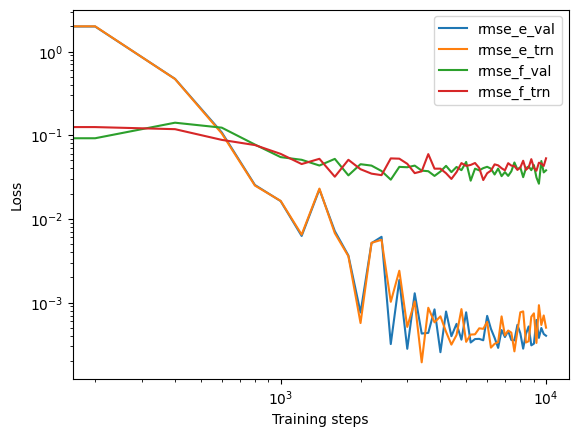

In [ ]:
with open("01.train/lcurve.out") as f:
    headers = f.readline().split()[1:]
lcurve = pd.DataFrame(np.loadtxt("01.train/lcurve.out"), columns=headers)
legends = ["rmse_e_val", "rmse_e_trn", "rmse_f_val", "rmse_f_trn"]
legends = ["rmse_e_val", "rmse_e_trn", "rmse_f_val", "rmse_f_trn"]
for legend in legends:
    plt.loglog(lcurve["step"], lcurve[legend], label=legend)
#     plt.plot(lcurve["step"], lcurve[legend], label=legend)
plt.legend()
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.show()

In [ ]:
training_systems = dpdata.LabeledSystem(f"00.data/abacus_md/training_data", fmt="deepmd/npy")

predict = training_systems.predict(f"01.train/graph.pb")

As shown later, ABACUS data contains "virials", but OpenMX doesn't.

In [ ]:
training_systems

Data Summary
Labeled System
-------------------
Frame Numbers      : 161
Atom Numbers       : 5
Including Virials  : Yes
Element List       :
-------------------
H  C
4  1

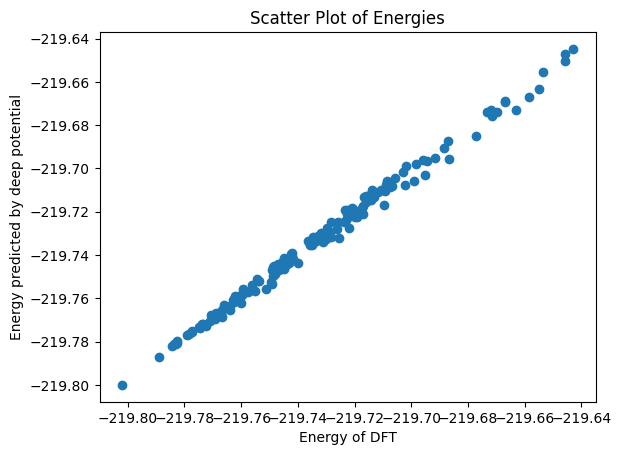

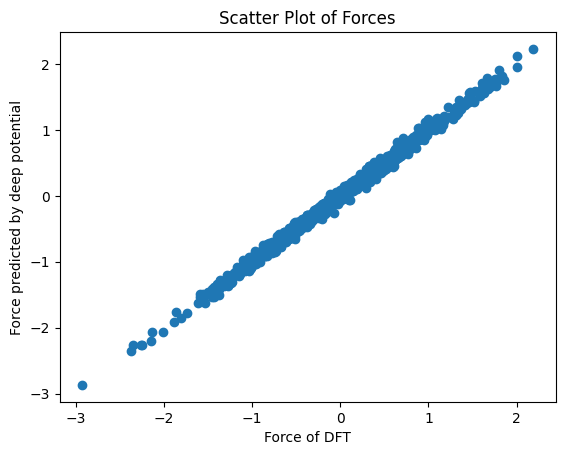

In [ ]:
# 1つ目のプロット
plt.figure()  # 新しい図を作成
plt.scatter(training_systems["energies"], predict["energies"])
plt.xlabel("Energy of DFT")
plt.ylabel("Energy predicted by deep potential")
plt.title('Scatter Plot of Energies')

# 2つ目のプロット
plt.figure()  # 別の新しい図を作成
plt.scatter(training_systems["forces"], predict["forces"])
plt.xlabel("Force of DFT")
plt.ylabel("Force predicted by deep potential")
plt.title('Scatter Plot of Forces')

# プロットの表示
plt.show()

In [ ]:
! python3 CH4_MD.py > tutorial.txt

Instructions for updating:
non-resource variables are not supported in the long term
2023-11-24 00:17:32.860775: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
/opt/homebrew/lib/python3.11/site-packages/ase/md/md.py:48: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


In [ ]:
filename="tutorial"

df = pd.read_csv(
    f"log/{filename}.log",
    delim_whitespace=True,
    names=["Time[ps]", "Etot/N[eV]", "Epot/N[eV]", "Ekin/N[eV]", "T[K]"],
    skiprows=1,
    header=None,
)
df

,Time[ps],Etot/N[eV],Epot/N[eV],Ekin/N[eV],T[K]
0,0.00,-43.8521,-43.8845,0.0324,250.7
1,0.01,-43.8784,-43.9381,0.0596,461.3
2,0.02,-43.8952,-43.9375,0.0423,327.0
3,0.03,-43.8897,-43.8975,0.0079,60.9
4,0.04,-43.8905,-43.9228,0.0323,249.8
...,...,...,...,...,...
76,0.76,-43.9117,-43.9507,0.0390,301.8
77,0.77,-43.9107,-43.9498,0.0390,301.9
78,0.78,-43.9095,-43.9483,0.0387,299.7
79,0.79,-43.9128,-43.9511,0.0383,296.4


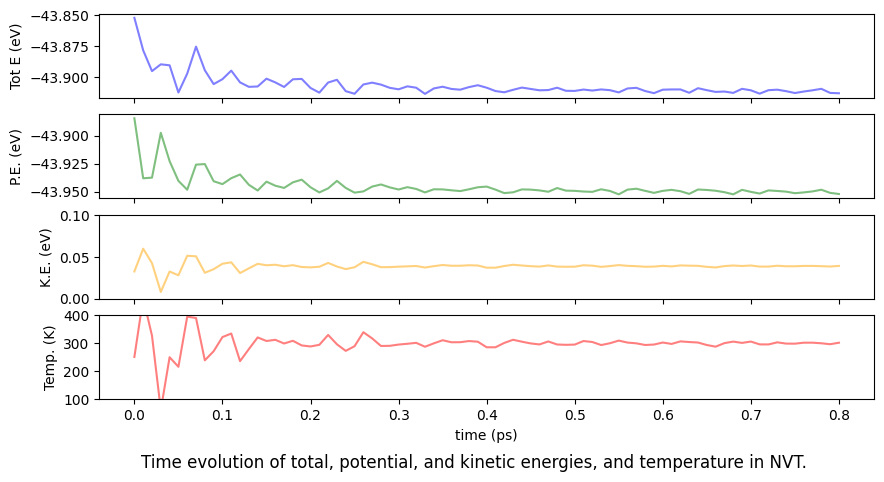

In [ ]:
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(4, 1, 1)
ax1.set_xticklabels([])  # x axis label
ax1.set_ylabel('Tot E (eV)')  # y axis label
ax1.plot(df["Time[ps]"], df["Etot/N[eV]"], color="blue",alpha=0.5)

ax2 = fig.add_subplot(4, 1, 2)
ax2.set_xticklabels([])  # x axis label
ax2.set_ylabel('P.E. (eV)')  # y axis label
ax2.plot(df["Time[ps]"], df["Epot/N[eV]"], color="green",alpha=0.5)

ax3 = fig.add_subplot(4, 1, 3)
ax3.set_xticklabels([])  # x axis label
ax3.set_ylabel('K.E. (eV)')  # y axis label
ax3.set_ylim([0.0, 0.1])
ax3.plot(df["Time[ps]"], df["Ekin/N[eV]"], color="orange",alpha=0.5)

ax4 = fig.add_subplot(4, 1, 4)
ax4.set_xlabel('time (ps)')  # x axis label
ax4.set_ylabel('Temp. (K)')  # y axis label
ax4.plot(df["Time[ps]"], df["T[K]"], color="red",alpha=0.5)
ax4.set_ylim([100., 400])

fig.suptitle("Time evolution of total, potential, and kinetic energies, and temperature in NVT.", y=0)

plt.show()

length mean value = 1.10, angle mean value = 109.04


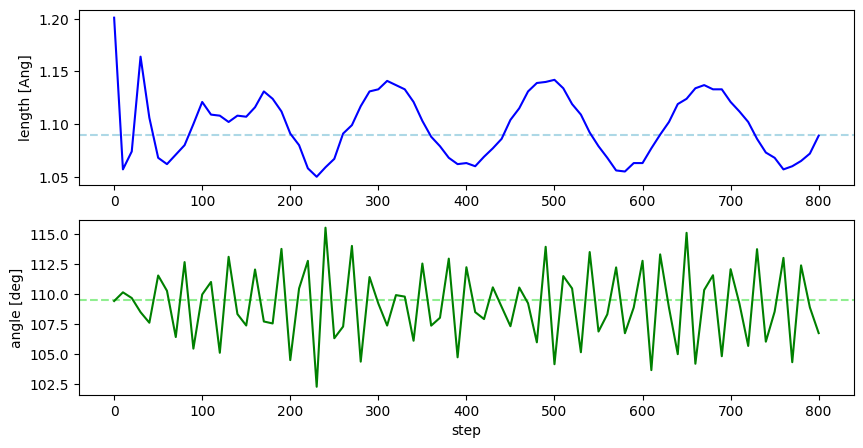

In [ ]:
data=np.genfromtxt("tutorial.txt")

fig=plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(2, 1, 1)
# plt.xlim(200,800)
ax1.set_ylabel('length [Ang]')  # y axis label
ax1.axhline(1.09,color="lightblue",linestyle="--")
ax1.plot(data[:,0], data[:,1], color="blue")

ax2 = fig.add_subplot(2, 1, 2)
# plt.xlim(200,800)
ax2.set_xlabel("step")
ax2.set_ylabel('angle [deg]')  # y axis label
ax2.axhline(109.5,color="lightgreen",linestyle="--")
ax2.plot(data[:,0], data[:,2], color="green")

print(f"length mean value = {data[20:,1].mean():1.2f}, angle mean value = {data[20:,2].mean():3.2f}")
plt.savefig("abacus_nn.png")
plt.show()

In [ ]:
data = dpdata.LabeledSystem("00.data/abacus_md", fmt="abacus/md")

coords=data["coords"]

# ファイルの書き込み関数
def write_file(file_name, content):
    with open(file_name, "w") as file:
        file.write(content)

# ファイルの追加書き込み関数
def append_file(file_name, content):
    with open(file_name, "a") as file:
        file.write(content)

def calculate_angle(v1, v2):
    # ベクトルv1とv2の内積を計算
    dot_product = np.dot(v1, v2)
    
    # ベクトルv1とv2のノルムを計算
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    
    # アークコサインを使用して角度を計算
    angle_rad = np.arccos(dot_product / (norm_v1 * norm_v2))
    
    # ラジアンから度に変換
    angle_deg = np.degrees(angle_rad)
    
    return angle_deg

cnt=0
write_file("ABACUS.txt","# time[fs] length[Å] length[Å] length[Å] length[Å] angle[deg] angle[deg] angle[deg] \n")
for coord in coords:
    #   print(type(coord))
    # print(coord)
    # print(coord[0])
    vec1=coord[4]-coord[0]
    vec2=coord[4]-coord[1]
    vec3=coord[4]-coord[2]
    vec4=coord[4]-coord[3]
    append_file("ABACUS.txt",f'{cnt:2.0f}   '+f'{np.linalg.norm(vec1):5.3f}   '+f'{np.linalg.norm(vec2):5.3f}   '+f'{np.linalg.norm(vec3):5.3f}   '+f'{calculate_angle(vec1,vec2):5.3f}   '+f'{calculate_angle(vec2,vec3):5.3f}   '+f'{calculate_angle(vec3,vec1):5.3f} \n')
    cnt+=1

In [26]:
# load data of abacus/md format
data = dpdata.LabeledSystem("00.data/abacus_md", fmt="abacus/md")
print("# the data contains %d frames" % len(data))

# random choose 40 index for validation_data
index_validation = np.random.choice(201, size=40, replace=False)

# other indexes are training_data
index_training = list(set(range(201)) - set(index_validation))
data_training = data.sub_system(index_training)
data_validation = data.sub_system(index_validation)

# all training data put into directory:"training_data"
data_training.to_deepmd_npy("00.data/abacus_md/training_data")

# all validation data put into directory:"validation_data"
data_validation.to_deepmd_npy("00.data/abacus_md/validation_data")

print("# the training data contains %d frames" % len(data_training))
print("# the validation data contains %d frames" % len(data_validation))

# the data contains 201 frames
# the training data contains 161 frames
# the validation data contains 40 frames


In [28]:
! dp neighbor-stat -s 00.data/abacus_md -r 6.0 -t H C

Instructions for updating:
non-resource variables are not supported in the long term
DEEPMD INFO    training data with min nbor dist: 1.0459205686110271
DEEPMD INFO    training data with max nbor size: [4 1]
DEEPMD INFO    min_nbor_dist: 1.045921
DEEPMD INFO    max_nbor_size: [4 1]


In [30]:
! bash train.sh

first index = 0
Instructions for updating:
non-resource variables are not supported in the long term
DEEPMD INFO    Calculate neighbor statistics... (add --skip-neighbor-stat to skip this step)
DEEPMD INFO    training data with min nbor dist: 1.0459205686110271
DEEPMD INFO    training data with max nbor size: [4 1]
DEEPMD INFO     _____               _____   __  __  _____           _     _  _   
DEEPMD INFO    |  __ \             |  __ \ |  \/  ||  __ \         | |   (_)| |  
DEEPMD INFO    | |  | |  ___   ___ | |__) || \  / || |  | | ______ | | __ _ | |_ 
DEEPMD INFO    | |  | | / _ \ / _ \|  ___/ | |\/| || |  | ||______|| |/ /| || __|
DEEPMD INFO    | |__| ||  __/|  __/| |     | |  | || |__| |        |   < | || |_ 
DEEPMD INFO    |_____/  \___| \___||_|     |_|  |_||_____/         |_|\_\|_| \__|
DEEPMD INFO    Please read and cite:
DEEPMD INFO    Wang, Zhang, Han and E, Comput.Phys.Comm. 228, 178-184 (2018)
DEEPMD INFO    Zeng et al, arXiv:2304.09409
DEEPMD INFO    See https://deepmd

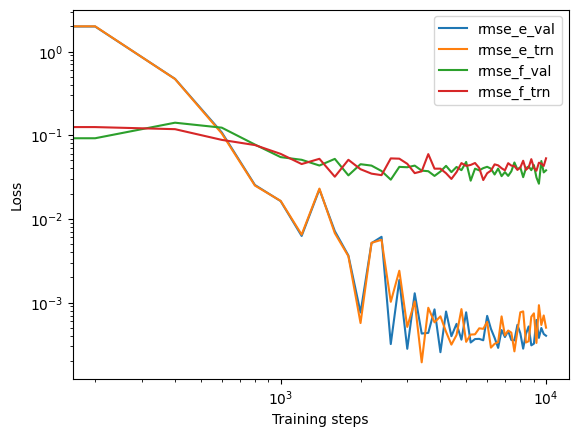

In [31]:
with open("01.train/lcurve.out") as f:
    headers = f.readline().split()[1:]
lcurve = pd.DataFrame(np.loadtxt("01.train/lcurve.out"), columns=headers)
legends = ["rmse_e_val", "rmse_e_trn", "rmse_f_val", "rmse_f_trn"]
legends = ["rmse_e_val", "rmse_e_trn", "rmse_f_val", "rmse_f_trn"]
for legend in legends:
    plt.loglog(lcurve["step"], lcurve[legend], label=legend)
#     plt.plot(lcurve["step"], lcurve[legend], label=legend)
plt.legend()
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.show()

In [186]:
training_systems = dpdata.LabeledSystem(f"00.data/abacus_md/training_data", fmt="deepmd/npy")

predict = training_systems.predict(f"01.train/graph.pb")

As shown later, ABACUS data contains "virials", but OpenMX doesn't.

In [187]:
training_systems

Data Summary
Labeled System
-------------------
Frame Numbers      : 161
Atom Numbers       : 5
Including Virials  : Yes
Element List       :
-------------------
H  C
4  1

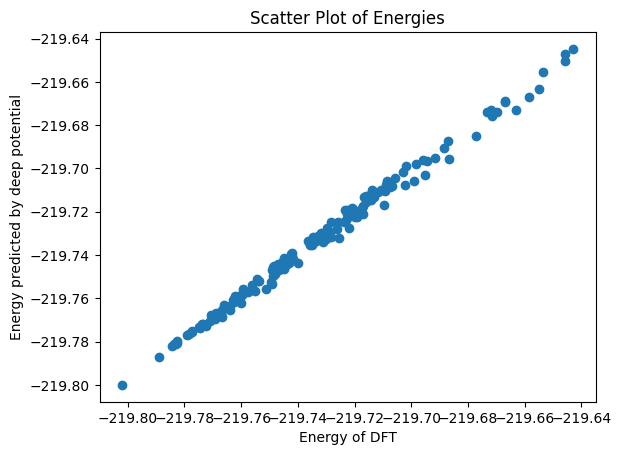

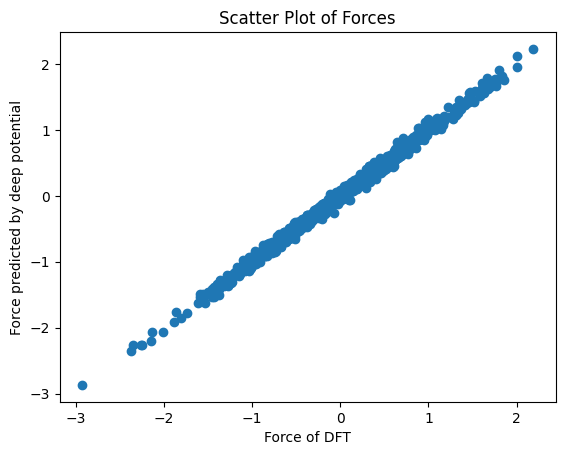

In [79]:
# 1つ目のプロット
plt.figure()  # 新しい図を作成
plt.scatter(training_systems["energies"], predict["energies"])
plt.xlabel("Energy of DFT")
plt.ylabel("Energy predicted by deep potential")
plt.title('Scatter Plot of Energies')

# 2つ目のプロット
plt.figure()  # 別の新しい図を作成
plt.scatter(training_systems["forces"], predict["forces"])
plt.xlabel("Force of DFT")
plt.ylabel("Force predicted by deep potential")
plt.title('Scatter Plot of Forces')

# プロットの表示
plt.show()

In [35]:
! python3 CH4_MD.py > tutorial.txt

Instructions for updating:
non-resource variables are not supported in the long term
2023-11-24 00:17:32.860775: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
/opt/homebrew/lib/python3.11/site-packages/ase/md/md.py:48: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


In [181]:
filename="tutorial"

df = pd.read_csv(
    f"log/{filename}.log",
    delim_whitespace=True,
    names=["Time[ps]", "Etot/N[eV]", "Epot/N[eV]", "Ekin/N[eV]", "T[K]"],
    skiprows=1,
    header=None,
)
df

,Time[ps],Etot/N[eV],Epot/N[eV],Ekin/N[eV],T[K]
0,0.00,-43.8521,-43.8845,0.0324,250.7
1,0.01,-43.8784,-43.9381,0.0596,461.3
2,0.02,-43.8952,-43.9375,0.0423,327.0
3,0.03,-43.8897,-43.8975,0.0079,60.9
4,0.04,-43.8905,-43.9228,0.0323,249.8
...,...,...,...,...,...
76,0.76,-43.9117,-43.9507,0.0390,301.8
77,0.77,-43.9107,-43.9498,0.0390,301.9
78,0.78,-43.9095,-43.9483,0.0387,299.7
79,0.79,-43.9128,-43.9511,0.0383,296.4


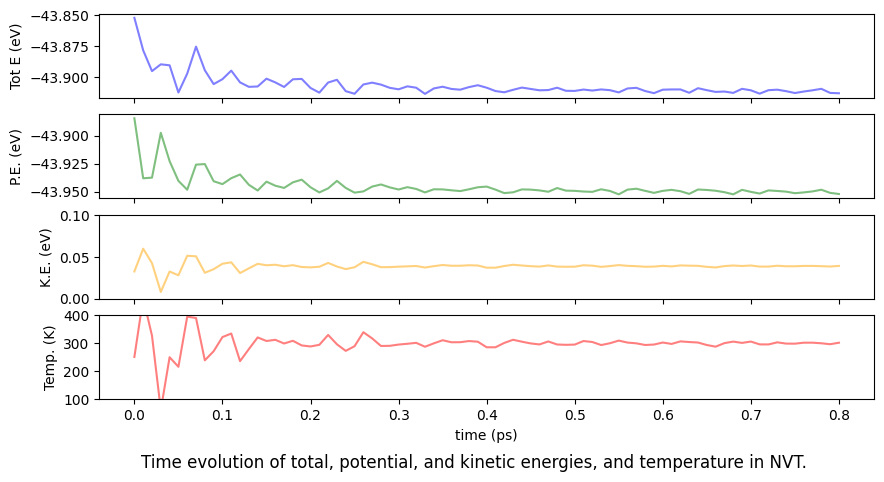

In [182]:
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(4, 1, 1)
ax1.set_xticklabels([])  # x axis label
ax1.set_ylabel('Tot E (eV)')  # y axis label
ax1.plot(df["Time[ps]"], df["Etot/N[eV]"], color="blue",alpha=0.5)

ax2 = fig.add_subplot(4, 1, 2)
ax2.set_xticklabels([])  # x axis label
ax2.set_ylabel('P.E. (eV)')  # y axis label
ax2.plot(df["Time[ps]"], df["Epot/N[eV]"], color="green",alpha=0.5)

ax3 = fig.add_subplot(4, 1, 3)
ax3.set_xticklabels([])  # x axis label
ax3.set_ylabel('K.E. (eV)')  # y axis label
ax3.set_ylim([0.0, 0.1])
ax3.plot(df["Time[ps]"], df["Ekin/N[eV]"], color="orange",alpha=0.5)

ax4 = fig.add_subplot(4, 1, 4)
ax4.set_xlabel('time (ps)')  # x axis label
ax4.set_ylabel('Temp. (K)')  # y axis label
ax4.plot(df["Time[ps]"], df["T[K]"], color="red",alpha=0.5)
ax4.set_ylim([100., 400])

fig.suptitle("Time evolution of total, potential, and kinetic energies, and temperature in NVT.", y=0)

plt.show()

length mean value = 1.10, angle mean value = 109.04


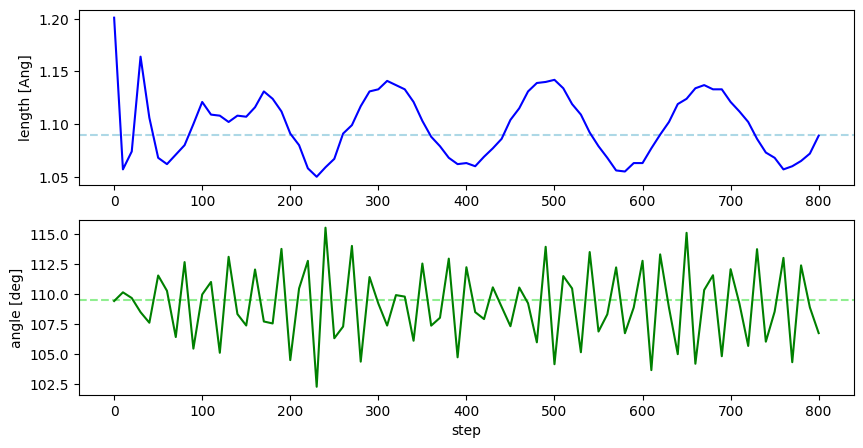

In [40]:
data=np.genfromtxt("tutorial.txt")

fig=plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(2, 1, 1)
# plt.xlim(200,800)
ax1.set_ylabel('length [Ang]')  # y axis label
ax1.axhline(1.09,color="lightblue",linestyle="--")
ax1.plot(data[:,0], data[:,1], color="blue")

ax2 = fig.add_subplot(2, 1, 2)
# plt.xlim(200,800)
ax2.set_xlabel("step")
ax2.set_ylabel('angle [deg]')  # y axis label
ax2.axhline(109.5,color="lightgreen",linestyle="--")
ax2.plot(data[:,0], data[:,2], color="green")

print(f"length mean value = {data[20:,1].mean():1.2f}, angle mean value = {data[20:,2].mean():3.2f}")
plt.savefig("abacus_nn.png")
plt.show()

In [268]:
data = dpdata.LabeledSystem("00.data/abacus_md", fmt="abacus/md")

coords=data["coords"]

# ファイルの書き込み関数
def write_file(file_name, content):
    with open(file_name, "w") as file:
        file.write(content)

# ファイルの追加書き込み関数
def append_file(file_name, content):
    with open(file_name, "a") as file:
        file.write(content)

def calculate_angle(v1, v2):
    # ベクトルv1とv2の内積を計算
    dot_product = np.dot(v1, v2)
    
    # ベクトルv1とv2のノルムを計算
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    
    # アークコサインを使用して角度を計算
    angle_rad = np.arccos(dot_product / (norm_v1 * norm_v2))
    
    # ラジアンから度に変換
    angle_deg = np.degrees(angle_rad)
    
    return angle_deg

cnt=0
write_file("ABACUS.txt","# time[fs] length[Å] length[Å] length[Å] length[Å] angle[deg] angle[deg] angle[deg] \n")
for coord in coords:
    #   print(type(coord))
    # print(coord)
    # print(coord[0])
    vec1=coord[4]-coord[0]
    vec2=coord[4]-coord[1]
    vec3=coord[4]-coord[2]
    vec4=coord[4]-coord[3]
    append_file("ABACUS.txt",f'{cnt:2.0f}   '+f'{np.linalg.norm(vec1):5.3f}   '+f'{np.linalg.norm(vec2):5.3f}   '+f'{np.linalg.norm(vec3):5.3f}   '+f'{calculate_angle(vec1,vec2):5.3f}   '+f'{calculate_angle(vec2,vec3):5.3f}   '+f'{calculate_angle(vec3,vec1):5.3f} \n')
    cnt+=1

## The demonstration with OpenMX
Compare learning results from ABCUS and OpenMX to verify that the DeePMD-kit is functioning properly. (not contain "virials")

### 1.Get DFT data
Place the results of calculations by OpenMX in the directory named `00.data`.

Input file “CH4.dat ”:
```
#
# MD or Geometry Optimization
#

MD.Type                  NVT_NH        # Nomd|Opt|NVE|NVT_VS|NVT_NH
MD.maxIter                 2000        # default=1
MD.TimeStep                 1.0        # default=0.5 (fs)
NH.Mass.HeatBath          30.0         # default = 20.0

<MD.TempControl
  5
  1    1000.0
  100  1000.0
  400   700.0
  700   400.0
 1000   300.0
MD.TempControl>
```
In this time, 200 frames of data, ranging from 1800 fs to 2000 fs, will be used.

### 2.Data preparation

The variable named label is the number which identifies data directories.

In [131]:
label=1

In [137]:
data = dpdata.LabeledSystem(f'{label}0.data/Methane', fmt = 'openmx')
print('# the data contains %d frames' % len(data))

# random choose 40 index for validation_data
index_validation = np.random.choice(len(data),size=40,replace=False)     

# other indexes are training_data
index_training = list(set(range(len(data)))-set(index_validation))       
data_training = data.sub_system(index_training)
data_validation = data.sub_system(index_validation)

# all training data put into directory:"training_data" 
data_training.to_deepmd_npy(f'{label}0.data/training_data')      

# all validation data put into directory:"validation_data"
data_validation.to_deepmd_npy(f'{label}0.data/validation_data')

print('# the training data contains %d frames' % len(data_training)) 
print('# the validation data contains %d frames' % len(data_validation))

# the data contains 200 frames
# the training data contains 160 frames
# the validation data contains 40 frames


In [127]:
training_systems = dpdata.LabeledSystem(f"{label}0.data/training_data", fmt="deepmd/npy")

In [128]:
training_systems # not include virials

Data Summary
Labeled System
-------------------
Frame Numbers      : 160
Atom Numbers       : 5
Including Virials  : No
Element List       :
-------------------
C  H
1  4

### 3.Prepare input script

Input file “input.json ”:
```
"model": {
        "type_map":	["H", "C"],
        "descriptor" :{
            "type":		"se_e2_a",
            "sel":		"auto",
            "rcut_smth":	0.50,
            "rcut":		6.00,
            "neuron":		[25, 50, 100],
            "resnet_dt":	false,
            "axis_neuron":	16,
            "seed":		1,
            "_comment":		" that's all"
        },
        "fitting_net" : {
            "neuron":		[240, 240, 240],
            "resnet_dt":	true,
            "seed":		1,
            "_comment":		" that's all"
        },
```

### 4.Train a model
After the training script is prepared, we can start the training with DeePMD-kit by simply running

In [26]:
! dp neighbor-stat -s 10.data -r 6.0 -t H C

Instructions for updating:
non-resource variables are not supported in the long term
DEEPMD INFO    training data with min nbor dist: 1.029958484357501
DEEPMD INFO    training data with max nbor size: [4 1]
DEEPMD INFO    min_nbor_dist: 1.029958
DEEPMD INFO    max_nbor_size: [4 1]


In [27]:
### Execute the deepmd-kit commands in sequence.　###
! bash train.sh

first index = 1
Instructions for updating:
non-resource variables are not supported in the long term
DEEPMD INFO    Calculate neighbor statistics... (add --skip-neighbor-stat to skip this step)
DEEPMD INFO    training data with min nbor dist: 1.029958484357501
DEEPMD INFO    training data with max nbor size: [4 1]
DEEPMD INFO     _____               _____   __  __  _____           _     _  _   
DEEPMD INFO    |  __ \             |  __ \ |  \/  ||  __ \         | |   (_)| |  
DEEPMD INFO    | |  | |  ___   ___ | |__) || \  / || |  | | ______ | | __ _ | |_ 
DEEPMD INFO    | |  | | / _ \ / _ \|  ___/ | |\/| || |  | ||______|| |/ /| || __|
DEEPMD INFO    | |__| ||  __/|  __/| |     | |  | || |__| |        |   < | || |_ 
DEEPMD INFO    |_____/  \___| \___||_|     |_|  |_||_____/         |_|\_\|_| \__|
DEEPMD INFO    Please read and cite:
DEEPMD INFO    Wang, Zhang, Han and E, Comput.Phys.Comm. 228, 178-184 (2018)
DEEPMD INFO    Zeng et al, arXiv:2304.09409
DEEPMD INFO    See https://deepmd.

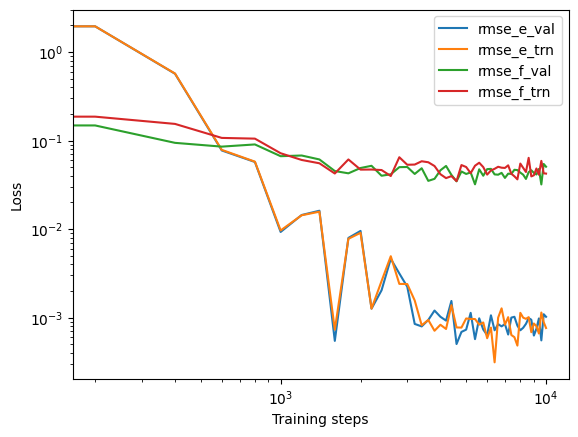

In [28]:
with open(f"{label}1.train/lcurve.out") as f:
      headers = f.readline().split()[1:]
lcurve = pd.DataFrame(np.loadtxt(f"{label}1.train/lcurve.out"), columns=headers)
legends = ["rmse_e_val", "rmse_e_trn", "rmse_f_val", "rmse_f_trn"]
for legend in legends:
      plt.loglog(lcurve["step"], lcurve[legend], label=legend)
plt.legend()
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.show()

### 5.test a model
The terminal should display the following

```
DEEPMD INFO    # ---------------output of dp test--------------- 
DEEPMD INFO    # testing system : ../00.data/validation_data
DEEPMD INFO    # number of test data : 40 
DEEPMD INFO    Energy MAE         : 6.695204e-02 eV
DEEPMD INFO    Energy RMSE        : 8.683650e-02 eV
DEEPMD INFO    Energy MAE/Natoms  : 3.719558e-03 eV
DEEPMD INFO    Energy RMSE/Natoms : 4.824250e-03 eV
DEEPMD INFO    Force  MAE         : 2.773996e-01 eV/A
DEEPMD INFO    Force  RMSE        : 3.574003e-01 eV/A
DEEPMD INFO    Virial MAE         : 3.173318e+00 eV
DEEPMD INFO    Virial RMSE        : 6.770684e+00 eV
DEEPMD INFO    Virial MAE/Natoms  : 1.762954e-01 eV
DEEPMD INFO    Virial RMSE/Natoms : 3.761491e-01 eV
DEEPMD INFO    # ----------------------------------------------- 
```

In [30]:
training_systems = dpdata.LabeledSystem(f"{label}0.data/training_data", fmt="deepmd/npy")

predict = training_systems.predict(f"{label}1.train/graph.pb")

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-11-24 19:59:05.272720: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [31]:
training_systems

Data Summary
Labeled System
-------------------
Frame Numbers      : 160
Atom Numbers       : 5
Including Virials  : No
Element List       :
-------------------
C  H
1  4

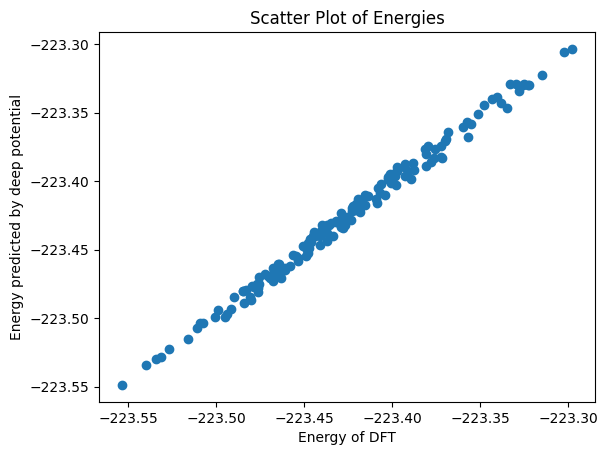

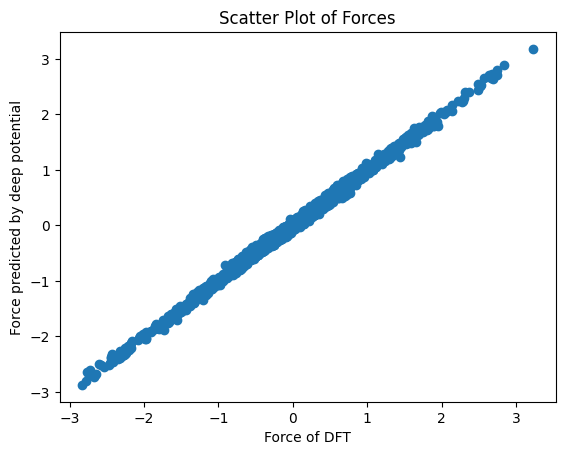

In [32]:
# 1つ目のプロット
plt.figure()  # 新しい図を作成
plt.scatter(training_systems["energies"], predict["energies"])
plt.xlabel("Energy of DFT")
plt.ylabel("Energy predicted by deep potential")
plt.title('Scatter Plot of Energies')

# 2つ目のプロット
plt.figure()  # 別の新しい図を作成
plt.scatter(training_systems["forces"], predict["forces"])
plt.xlabel("Force of DFT")
plt.ylabel("Force predicted by deep potential")
plt.title('Scatter Plot of Forces')

# プロットの表示
plt.show()

### 6.Run MD with ASE

In [34]:
filename="openmx"

In [35]:
if os.path.exists(f"log/{filename}.log"):
    os.remove(f"log/{filename}.log")

! python3 CH4_MD.py > openmx.txt

Instructions for updating:
non-resource variables are not supported in the long term
2023-11-24 20:00:32.997196: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
/opt/homebrew/lib/python3.11/site-packages/ase/md/md.py:48: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


In [36]:
df = pd.read_csv(
    f"log/{filename}.log",
    delim_whitespace=True,
    names=["Time[ps]", "Etot/N[eV]", "Epot/N[eV]", "Ekin/N[eV]", "T[K]"],
    skiprows=1,
    header=None,
)
df

,Time[ps],Etot/N[eV],Epot/N[eV],Ekin/N[eV],T[K]
0,0.00,-44.6825,-44.7098,0.0273,210.9
1,0.01,-44.6555,-44.6863,0.0308,237.9
2,0.02,-44.6665,-44.6703,0.0038,29.1
3,0.03,-44.6723,-44.6809,0.0086,66.4
4,0.04,-44.6716,-44.6960,0.0243,188.2
...,...,...,...,...,...
76,0.76,-44.6518,-44.6929,0.0411,318.0
77,0.77,-44.6509,-44.6904,0.0395,305.9
78,0.78,-44.6482,-44.6847,0.0365,282.6
79,0.79,-44.6534,-44.6920,0.0386,298.7


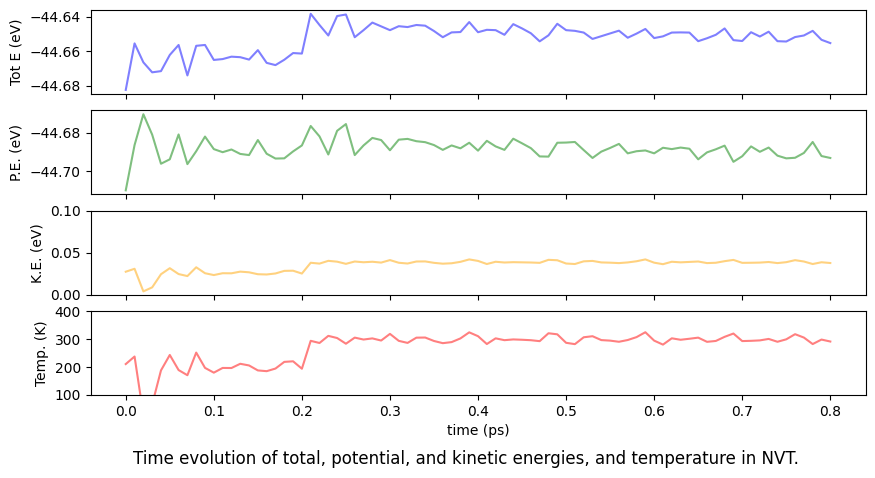

In [37]:
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(4, 1, 1)
ax1.set_xticklabels([])  # x axis label
ax1.set_ylabel('Tot E (eV)')  # y axis label
ax1.plot(df["Time[ps]"], df["Etot/N[eV]"], color="blue",alpha=0.5)

ax2 = fig.add_subplot(4, 1, 2)
ax2.set_xticklabels([])  # x axis label
ax2.set_ylabel('P.E. (eV)')  # y axis label
ax2.plot(df["Time[ps]"], df["Epot/N[eV]"], color="green",alpha=0.5)

ax3 = fig.add_subplot(4, 1, 3)
ax3.set_xticklabels([])  # x axis label
ax3.set_ylabel('K.E. (eV)')  # y axis label
ax3.set_ylim([0.0, 0.1])
ax3.plot(df["Time[ps]"], df["Ekin/N[eV]"], color="orange",alpha=0.5)

ax4 = fig.add_subplot(4, 1, 4)
ax4.set_xlabel('time (ps)')  # x axis label
ax4.set_ylabel('Temp. (K)')  # y axis label
ax4.plot(df["Time[ps]"], df["T[K]"], color="red",alpha=0.5)
ax4.set_ylim([100., 400])

fig.suptitle("Time evolution of total, potential, and kinetic energies, and temperature in NVT.", y=0)

plt.show()

length mean value = 1.10, angle mean value = 109.08


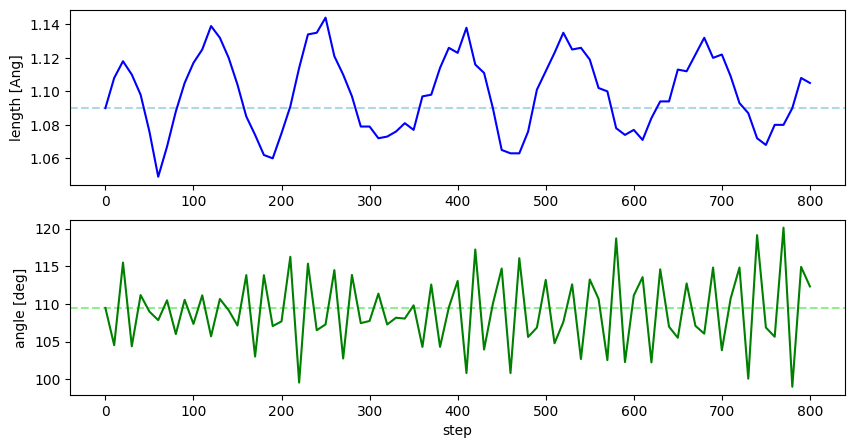

In [38]:
data=np.genfromtxt(f"{filename}.txt")

fig=plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(2, 1, 1)
# plt.xlim(200,800)
ax1.set_ylabel('length [Ang]')  # y axis label
ax1.axhline(1.09,color="lightblue",linestyle="--")
ax1.plot(data[:,0], data[:,1], color="blue")

ax2 = fig.add_subplot(2, 1, 2)
# plt.xlim(200,800)
ax2.set_xlabel("step")
ax2.set_ylabel('angle [deg]')  # y axis label
ax2.axhline(109.5,color="lightgreen",linestyle="--")
ax2.plot(data[:,0], data[:,4], color="green")

print(f"length mean value = {data[20:,1].mean():1.2f}, angle mean value = {data[20:,4].mean():3.2f}")
# plt.savefig(f"{filename}.png")
plt.show()

### data plot

length mean value = 1.10, angle mean value = 109.79


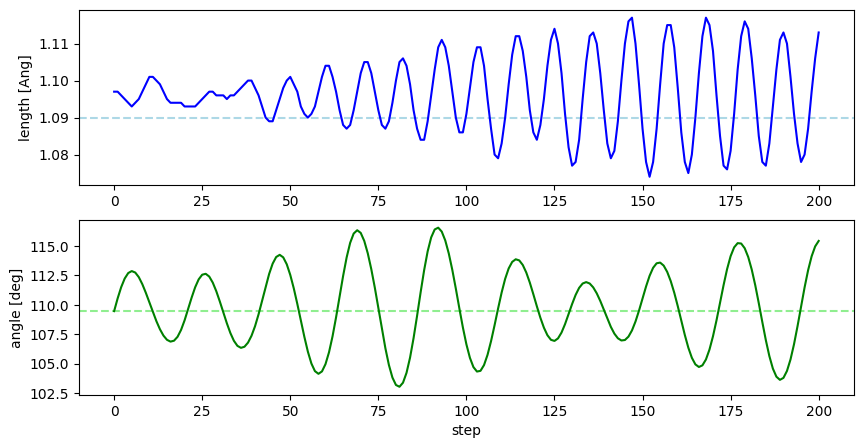

In [41]:
### ABACUS data plot ###
data=np.genfromtxt("abacus.txt")

fig=plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(2, 1, 1)
# plt.xlim(1000,2000)
ax1.set_ylabel('length [Ang]')  # y axis label
ax1.axhline(1.09,color="lightblue",linestyle="--")
ax1.plot(data[:,0], data[:,1], color="blue")

ax2 = fig.add_subplot(2, 1, 2)
# plt.xlim(1000,2000)
ax2.set_xlabel("step")
ax2.set_ylabel('angle [deg]')  # y axis label
ax2.axhline(109.5,color="lightgreen",linestyle="--")
ax2.plot(data[:,0], data[:,4], color="green")

print(f"length mean value = {data[:,1].mean():1.2f}, angle mean value = {data[:,4].mean():3.2f}")
# plt.savefig("abacus.png")
plt.show()

length mean value = 1.09, angle mean value = 109.47


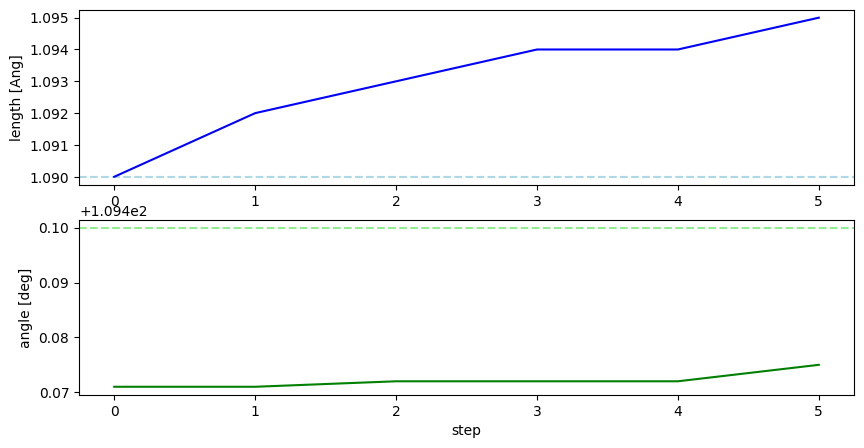

In [80]:
### OpenMX data plot ###
data=np.genfromtxt("Opt_met.txt")

fig=plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(2, 1, 1)
ax1.set_ylabel('length [Ang]')  # y axis label
ax1.axhline(1.09,color="lightblue",linestyle="--")
ax1.plot(data[:,0], data[:,1], color="blue")

ax2 = fig.add_subplot(2, 1, 2)
ax2.set_xlabel("step")
ax2.set_ylabel('angle [deg]')  # y axis label
ax2.axhline(109.5,color="lightgreen",linestyle="--")
ax2.plot(data[:,0], data[:,4], color="green")

print(f"length mean value = {data[:,1].mean():1.2f}, angle mean value = {data[:,4].mean():3.2f}")
# plt.savefig("geometry/openmx.png")
plt.show()

## 【Example1】H2O
There is no comparison with ABACUS.

### 1.Get DFT data

|                  | reference | calculation | Error(%) |
|------------------|-----------|-------------|----------|
| bond length (Å)  | 0.9584    | 0.970       |    1.21  |
| bond angle (deg) | 104.45    | 103.785     |   0.63667|

length mean value = 0.97, angle mean value = 103.62


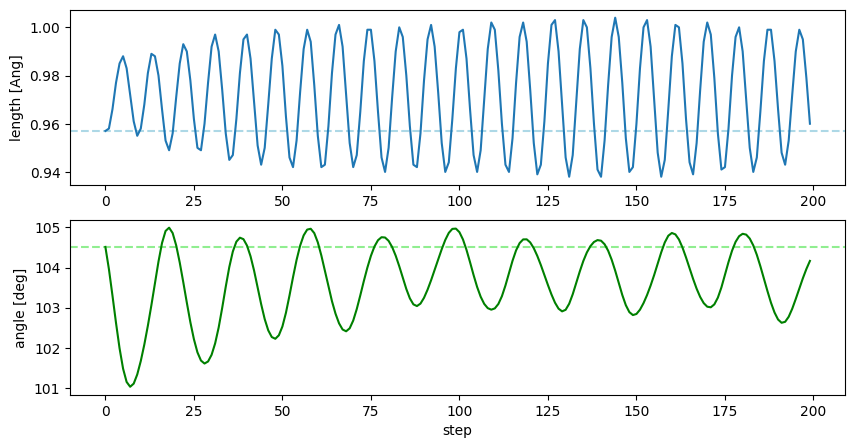

In [141]:
import numpy as np
import matplotlib.pyplot as plt

data=np.genfromtxt(f"20.data/H2O.txt")

fig=plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(2, 1, 1)
# plt.xlim(200,800)
ax1.set_ylabel('length [Ang]')  # y axis label
ax1.axhline(0.957,color="lightblue",linestyle="--")
ax1.plot(data[:,0], data[:,1])
# ax1.plot(data[:,0], data[:,2])
# ax1.plot(data[:,0], data[:,3])

ax2 = fig.add_subplot(2, 1, 2)
# plt.xlim(200,800)
ax2.set_xlabel("step")
ax2.set_ylabel('angle [deg]')  # y axis label
ax2.axhline(104.5,color="lightgreen",linestyle="--")
ax2.plot(data[:,0], data[:,3],color="green")
# ax2.plot(data[:,0], data[:,5])
# ax2.plot(data[:,0], data[:,6])

# plt.savefig(f"graphic/{filename}.png")
print(f"length mean value = {data[:,1].mean():1.2f}, angle mean value = {data[:,3].mean():3.2f}")
plt.show()

### 2.Data preparation

In [233]:
label=2

In [149]:
import dpdata
import numpy as np
data = dpdata.LabeledSystem(f'{label}0.data/H2O', fmt = 'openmx') 
# data = dpdata.LabeledSystem('10.data/traj6', fmt = 'qe/cp/traj') 
print('# the data contains %d frames' % len(data))
# random choose 40 index for validation_data
index_validation = np.random.choice(len(data),size=40,replace=False)     
# other indexes are training_data
index_training = list(set(range(len(data)))-set(index_validation))       
data_training = data.sub_system(index_training)
data_validation = data.sub_system(index_validation)
# all training data put into directory:"training_data" 
data_training.to_deepmd_npy(f'{label}0.data/training_data')               
# all validation data put into directory:"validation_data"
data_validation.to_deepmd_npy(f'{label}0.data/validation_data')           
print('# the training data contains %d frames' % len(data_training)) 
print('# the validation data contains %d frames' % len(data_validation)) 

# the data contains 200 frames
# the training data contains 160 frames
# the validation data contains 40 frames


In [187]:
training_systems = dpdata.LabeledSystem(f"{label}0.data/training_data", fmt="deepmd/npy")
training_systems

Data Summary
Labeled System
-------------------
Frame Numbers      : 160
Atom Numbers       : 3
Including Virials  : No
Element List       :
-------------------
O  H
1  2

### 3.Prepare input script

In [188]:
# ! dp neighbor-stat -s 20.data -r 6.0 -t O H
! bash train.sh

first index = 2
Instructions for updating:
non-resource variables are not supported in the long term
DEEPMD INFO    Calculate neighbor statistics... (add --skip-neighbor-stat to skip this step)
DEEPMD INFO    training data with min nbor dist: 0.9258628711099713
DEEPMD INFO    training data with max nbor size: [1 2]
DEEPMD INFO     _____               _____   __  __  _____           _     _  _   
DEEPMD INFO    |  __ \             |  __ \ |  \/  ||  __ \         | |   (_)| |  
DEEPMD INFO    | |  | |  ___   ___ | |__) || \  / || |  | | ______ | | __ _ | |_ 
DEEPMD INFO    | |  | | / _ \ / _ \|  ___/ | |\/| || |  | ||______|| |/ /| || __|
DEEPMD INFO    | |__| ||  __/|  __/| |     | |  | || |__| |        |   < | || |_ 
DEEPMD INFO    |_____/  \___| \___||_|     |_|  |_||_____/         |_|\_\|_| \__|
DEEPMD INFO    Please read and cite:
DEEPMD INFO    Wang, Zhang, Han and E, Comput.Phys.Comm. 228, 178-184 (2018)
DEEPMD INFO    Zeng et al, arXiv:2304.09409
DEEPMD INFO    See https://deepmd

### 4.Train a model

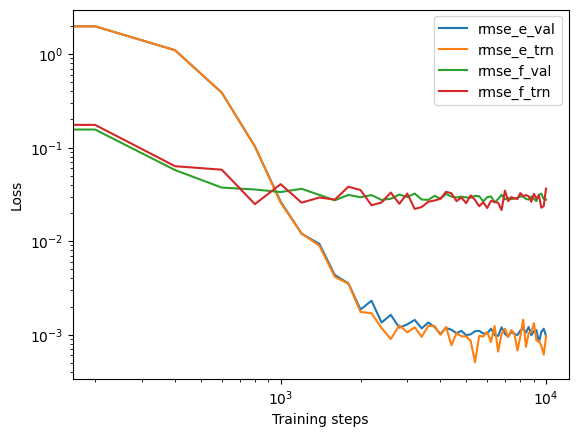

In [189]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
with open(f"{label}1.train/lcurve.out") as f:
      headers = f.readline().split()[1:]
lcurve = pd.DataFrame(np.loadtxt(f"{label}1.train/lcurve.out"), columns=headers)
legends = ["rmse_e_val", "rmse_e_trn", "rmse_f_val", "rmse_f_trn"]
for legend in legends:
      plt.loglog(lcurve["step"], lcurve[legend], label=legend)
plt.legend()
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.show()

### 5.test a model

In [234]:
import dpdata

training_systems = dpdata.LabeledSystem(f"{label}0.data/training_data", fmt="deepmd/npy")

predict = training_systems.predict(f"{label}1.train/graph.pb")

In [236]:
training_systems["energies"]

array([-475.56659457, -475.5573427 , -475.52033522, -475.50863432,
       -475.53448514, -475.53992742, -475.51053912, -475.53502937,
       -475.56278498, -475.54536969, -475.51570928, -475.51462083,
       -475.5434649 , -475.51897465, -475.54509758, -475.53911107,
       -475.52659384, -475.55271677, -475.55951961, -475.53040343,
       -475.55162831, -475.553261  , -475.52142367, -475.53040343,
       -475.55162831, -475.55434945, -475.53856685, -475.54210433,
       -475.55707059, -475.55571002, -475.54292067, -475.54292067,
       -475.5573427 , -475.55489368, -475.54482547, -475.54972352,
       -475.55543791, -475.5475466 , -475.55026774, -475.56060807,
       -475.55843116, -475.55353311, -475.55598213, -475.55870327,
       -475.55897539, -475.55298888, -475.5475466 , -475.55271677,
       -475.55979173, -475.55353311, -475.55679848, -475.56060807,
       -475.54890717, -475.56060807, -475.55571002, -475.55217254,
       -475.55815904, -475.56224075, -475.55571002, -475.54999

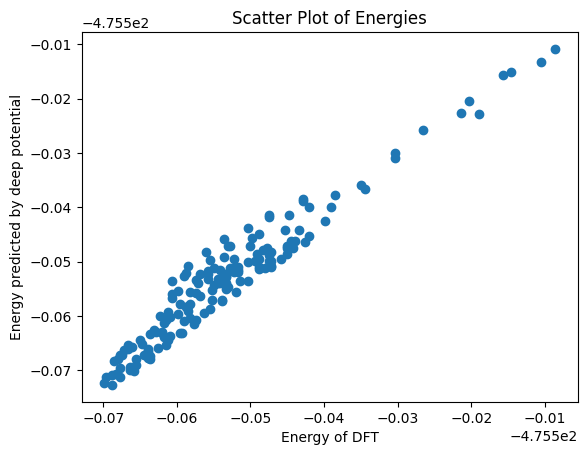

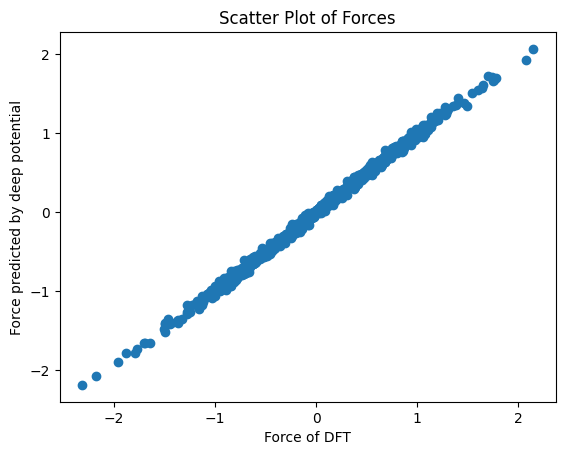

In [235]:
# 1つ目のプロット
plt.figure()  # 新しい図を作成
plt.scatter(training_systems["energies"], predict["energies"])
plt.xlabel("Energy of DFT")
plt.ylabel("Energy predicted by deep potential")
plt.title('Scatter Plot of Energies')

# 2つ目のプロット
plt.figure()  # 別の新しい図を作成
plt.scatter(training_systems["forces"], predict["forces"])
plt.xlabel("Force of DFT")
plt.ylabel("Force predicted by deep potential")
plt.title('Scatter Plot of Forces')

# プロットの表示
plt.show()

### 6.Run MD with ASE

In [192]:
filename="H2O"

In [193]:
if os.path.exists(f"log/{filename}.log"):
    os.remove(f"log/{filename}.log")

! python3 H2O_MD.py > H2O.txt

Instructions for updating:
non-resource variables are not supported in the long term
2023-11-25 18:48:30.003567: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
/opt/homebrew/lib/python3.11/site-packages/ase/md/md.py:48: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


In [194]:
df = pd.read_csv(
    f"log/{filename}.log",
    delim_whitespace=True,
    names=["Time[ps]", "Etot/N[eV]", "Epot/N[eV]", "Ekin/N[eV]", "T[K]"],
    skiprows=1,
    header=None,
)
df

,Time[ps],Etot/N[eV],Epot/N[eV],Ekin/N[eV],T[K]
0,0.00,-158.5001,-158.5218,0.0217,168.2
1,0.01,-158.4714,-158.5152,0.0437,338.3
2,0.02,-158.4674,-158.5060,0.0385,297.9
3,0.03,-158.4769,-158.5105,0.0337,260.6
4,0.04,-158.4792,-158.5131,0.0339,262.0
...,...,...,...,...,...
76,0.76,-158.4846,-158.5235,0.0389,300.8
77,0.77,-158.4832,-158.5227,0.0395,305.9
78,0.78,-158.4820,-158.5216,0.0397,307.1
79,0.79,-158.4843,-158.5230,0.0387,299.1


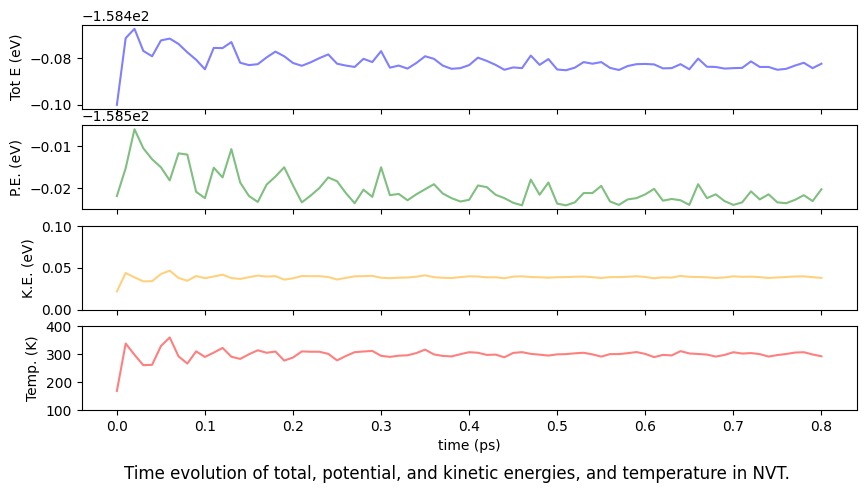

In [195]:
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(4, 1, 1)
ax1.set_xticklabels([])  # x axis label
ax1.set_ylabel('Tot E (eV)')  # y axis label
ax1.plot(df["Time[ps]"], df["Etot/N[eV]"], color="blue",alpha=0.5)

ax2 = fig.add_subplot(4, 1, 2)
ax2.set_xticklabels([])  # x axis label
ax2.set_ylabel('P.E. (eV)')  # y axis label
ax2.plot(df["Time[ps]"], df["Epot/N[eV]"], color="green",alpha=0.5)

ax3 = fig.add_subplot(4, 1, 3)
ax3.set_xticklabels([])  # x axis label
ax3.set_ylabel('K.E. (eV)')  # y axis label
ax3.set_ylim([0.0, 0.1])
ax3.plot(df["Time[ps]"], df["Ekin/N[eV]"], color="orange",alpha=0.5)

ax4 = fig.add_subplot(4, 1, 4)
ax4.set_xlabel('time (ps)')  # x axis label
ax4.set_ylabel('Temp. (K)')  # y axis label
ax4.plot(df["Time[ps]"], df["T[K]"], color="red",alpha=0.5)
ax4.set_ylim([100., 400])

fig.suptitle("Time evolution of total, potential, and kinetic energies, and temperature in NVT.", y=0)

plt.show()

length mean value = 0.97, angle mean value = 103.69


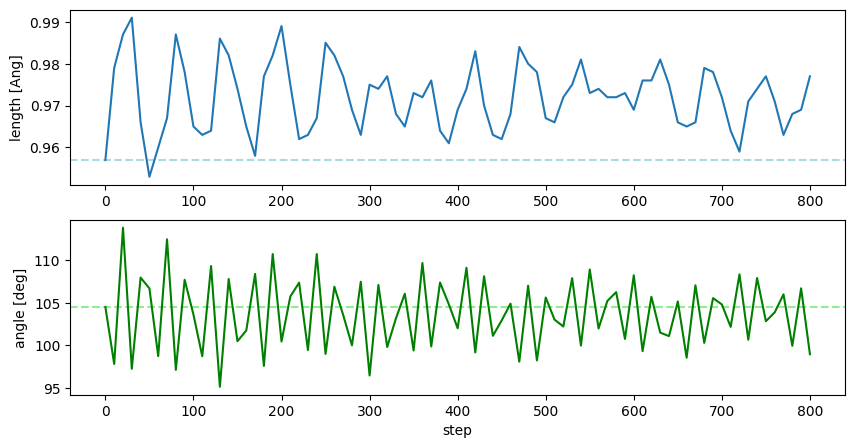

In [196]:
import numpy as np
import matplotlib.pyplot as plt

data=np.genfromtxt(f"H2O.txt")

fig=plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(2, 1, 1)
# plt.xlim(200,800)
ax1.set_ylabel('length [Ang]')  # y axis label
ax1.axhline(0.957,color="lightblue",linestyle="--")
ax1.plot(data[:,0], data[:,1])
# ax1.plot(data[:,0], data[:,2])
# ax1.plot(data[:,0], data[:,3])

ax2 = fig.add_subplot(2, 1, 2)
# plt.xlim(200,800)
ax2.set_xlabel("step")
ax2.set_ylabel('angle [deg]')  # y axis label
ax2.axhline(104.5,color="lightgreen",linestyle="--")
ax2.plot(data[:,0], data[:,3],color="green")
# ax2.plot(data[:,0], data[:,5])
# ax2.plot(data[:,0], data[:,6])

# plt.savefig(f"graphic/{filename}.png")
print(f"length mean value = {data[:,1].mean():1.2f}, angle mean value = {data[:,3].mean():3.2f}")
plt.show()

## 【Example2】Cdia
There is no comparison with ABACUS.

3.61696


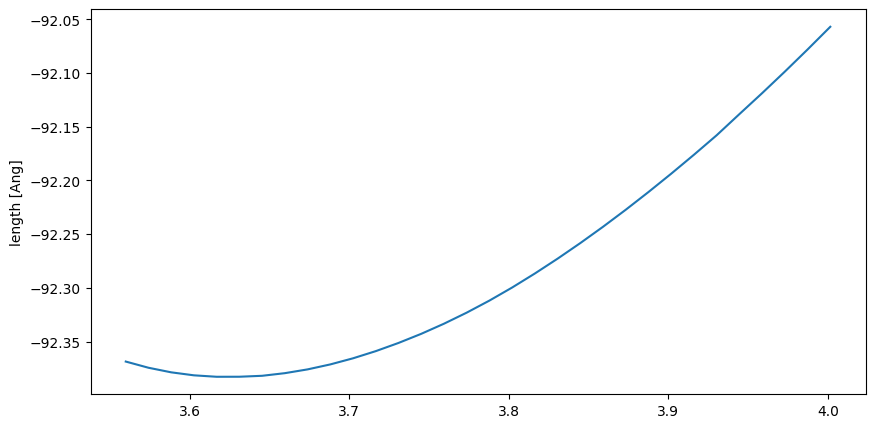

In [248]:
import numpy as np
import matplotlib.pyplot as plt

data=np.genfromtxt(f"Cdia/cdia.EvsLC")

fig=plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1, 1, 1)
ax1.set_ylabel('length [Ang]')  # y axis label
ax1.plot(data[:,2], data[:,9])
# ax1.plot(data[:,0], data[:,2])
# ax1.plot(data[:,0], data[:,3])

# ax2 = fig.add_subplot(2, 1, 2)
# # plt.xlim(200,800)
# ax2.set_xlabel("step")
# ax2.set_ylabel('angle [deg]')  # y axis label
# ax2.axhline(104.5,color="lightgreen",linestyle="--")
# ax2.plot(data[:,0], data[:,3],color="green")
# # ax2.plot(data[:,0], data[:,5])
# # ax2.plot(data[:,0], data[:,6])

# plt.savefig(f"graphic/{filename}.png")
i_min=np.argmin(data[:,9])
a=data[i_min,2]
print(a)
plt.show()

In [197]:
label=3

In [91]:
import dpdata
import numpy as np
data = dpdata.LabeledSystem(f'{label}0.data/Cdia', fmt = 'openmx') 
# data = dpdata.LabeledSystem('10.data/traj6', fmt = 'qe/cp/traj') 
print('# the data contains %d frames' % len(data))
# random choose 40 index for validation_data
index_validation = np.random.choice(len(data),size=100,replace=False)     
# other indexes are training_data
index_training = list(set(range(len(data)))-set(index_validation))       
data_training = data.sub_system(index_training)
data_validation = data.sub_system(index_validation)
# all training data put into directory:"training_data" 
data_training.to_deepmd_npy(f'{label}0.data/training_data')               
# all validation data put into directory:"validation_data"
data_validation.to_deepmd_npy(f'{label}0.data/validation_data')           
print('# the training data contains %d frames' % len(data_training)) 
print('# the validation data contains %d frames' % len(data_validation)) 

# the data contains 1000 frames
# the training data contains 900 frames
# the validation data contains 100 frames


In [92]:
training_systems = dpdata.LabeledSystem(f"{label}0.data/training_data", fmt="deepmd/npy")
training_systems

Data Summary
Labeled System
-------------------
Frame Numbers      : 900
Atom Numbers       : 16
Including Virials  : No
Element List       :
-------------------
C
16

### 3.Prepare input script

Serial training (not parallel)

In [185]:
# ! dp neighbor-stat -s 30.data -r 6.0 -t C
! bash train.sh

first index = 2
Instructions for updating:
non-resource variables are not supported in the long term
DEEPMD INFO    Calculate neighbor statistics... (add --skip-neighbor-stat to skip this step)
DEEPMD INFO    training data with min nbor dist: 0.9258628711099713
DEEPMD INFO    training data with max nbor size: [1 2]
DEEPMD INFO     _____               _____   __  __  _____           _     _  _   
DEEPMD INFO    |  __ \             |  __ \ |  \/  ||  __ \         | |   (_)| |  
DEEPMD INFO    | |  | |  ___   ___ | |__) || \  / || |  | | ______ | | __ _ | |_ 
DEEPMD INFO    | |  | | / _ \ / _ \|  ___/ | |\/| || |  | ||______|| |/ /| || __|
DEEPMD INFO    | |__| ||  __/|  __/| |     | |  | || |__| |        |   < | || |_ 
DEEPMD INFO    |_____/  \___| \___||_|     |_|  |_||_____/         |_|\_\|_| \__|
DEEPMD INFO    Please read and cite:
DEEPMD INFO    Wang, Zhang, Han and E, Comput.Phys.Comm. 228, 178-184 (2018)
DEEPMD INFO    Zeng et al, arXiv:2304.09409
DEEPMD INFO    See https://deepmd

### 4.Train a model

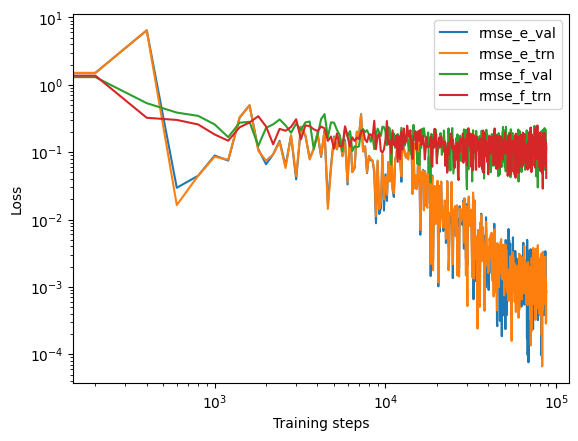

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
with open(f"{label}1.train/lcurve.out") as f:
      headers = f.readline().split()[1:]
lcurve = pd.DataFrame(np.loadtxt(f"{label}1.train/lcurve.out"), columns=headers)
legends = ["rmse_e_val", "rmse_e_trn", "rmse_f_val", "rmse_f_trn"]
for legend in legends:
      plt.loglog(lcurve["step"], lcurve[legend], label=legend)
plt.legend()
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.show()

### 5.test a model

In [198]:
import dpdata

training_systems = dpdata.LabeledSystem(f"{label}0.data/training_data", fmt="deepmd/npy")

predict = training_systems.predict(f"{label}1.train/graph.pb")

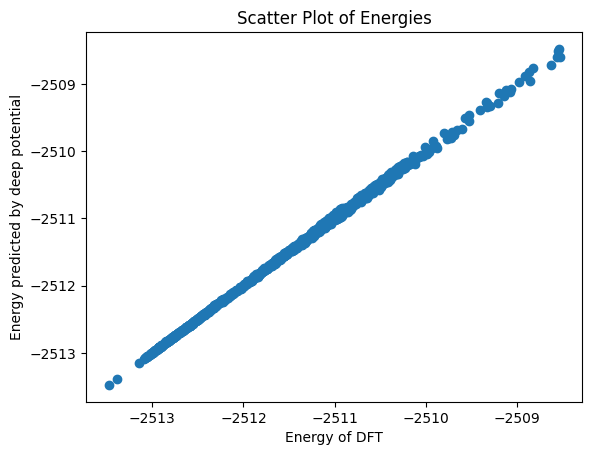

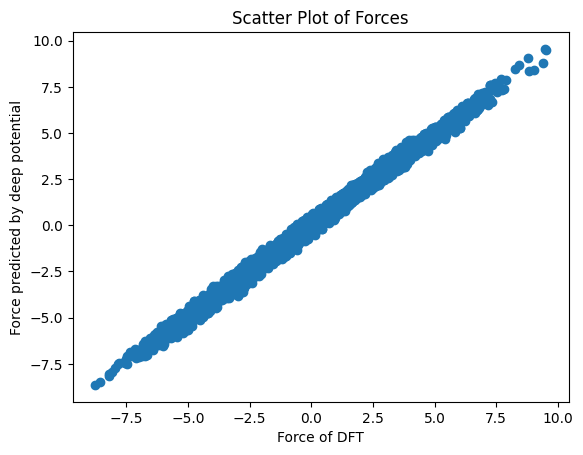

In [199]:
# 1つ目のプロット
plt.figure()  # 新しい図を作成
plt.scatter(training_systems["energies"], predict["energies"])
plt.xlabel("Energy of DFT")
plt.ylabel("Energy predicted by deep potential")
plt.title('Scatter Plot of Energies')

# 2つ目のプロット
plt.figure()  # 別の新しい図を作成
plt.scatter(training_systems["forces"], predict["forces"])
plt.xlabel("Force of DFT")
plt.ylabel("Force predicted by deep potential")
plt.title('Scatter Plot of Forces')

# プロットの表示
plt.show()

### 6.Run MD with ASE

In [121]:
filename="Cdia"

In [119]:
if os.path.exists(f"log/{filename}.log"):
    os.remove(f"log/{filename}.log")
    
! python3 MD.py

Instructions for updating:
non-resource variables are not supported in the long term
2023-11-25 15:53:06.440394: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
/opt/homebrew/lib/python3.11/site-packages/ase/md/md.py:48: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))
# warning: loc idx out of upper bound (ignored if warned for more than 10 times) 
# warning: loc idx out of lower bound (ignored if warned for more than 10 times) 
# warning: loc idx out of upper bound (ignored if warned for more than 10 times) 
# warning: loc idx out of upper bound (ignored if warned for more than 10 times) 
# warning: loc idx out of upper bound (ignored if warned for more than 10 times) 
# warning: loc idx out of upper bound

In [122]:
import pandas as pd

df = pd.read_csv(
    f"log/{filename}.log",
    delim_whitespace=True,
    names=["Time[ps]", "Etot/N[eV]", "Epot/N[eV]", "Ekin/N[eV]", "T[K]"],
    skiprows=1,
    header=None,
)
df

,Time[ps],Etot/N[eV],Epot/N[eV],Ekin/N[eV],T[K]
0,0.00,-157.0257,-157.0924,0.0666,515.4
1,0.01,-157.0104,-157.0455,0.0350,271.1
2,0.02,-156.9925,-157.0218,0.0293,226.3
3,0.03,-156.9767,-157.0371,0.0604,466.9
4,0.04,-156.9689,-157.0309,0.0620,479.8
...,...,...,...,...,...
116,1.16,-156.9220,-157.0099,0.0879,680.0
117,1.17,-156.9189,-157.0010,0.0821,635.5
118,1.18,-156.9207,-156.9991,0.0783,605.8
119,1.19,-156.9201,-157.0038,0.0837,647.5


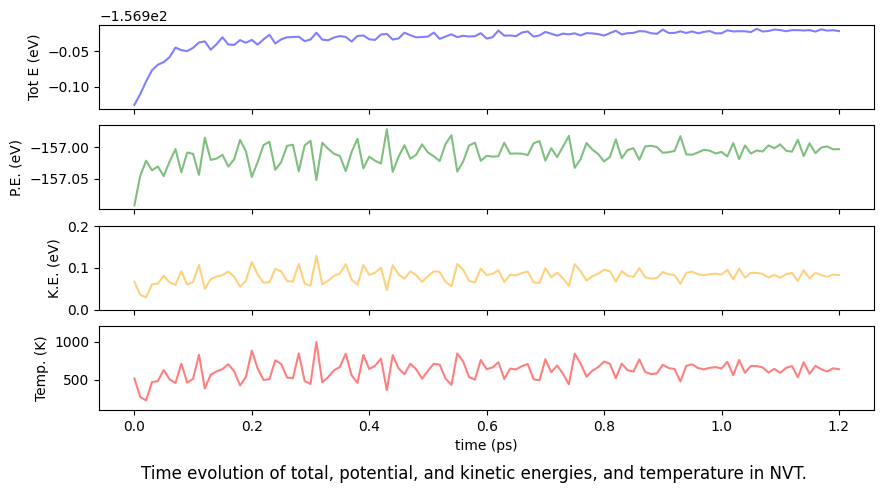

In [123]:
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(4, 1, 1)
ax1.set_xticklabels([])  # x axis label
ax1.set_ylabel('Tot E (eV)')  # y axis label
ax1.plot(df["Time[ps]"], df["Etot/N[eV]"], color="blue",alpha=0.5)

ax2 = fig.add_subplot(4, 1, 2)
ax2.set_xticklabels([])  # x axis label
ax2.set_ylabel('P.E. (eV)')  # y axis label
ax2.plot(df["Time[ps]"], df["Epot/N[eV]"], color="green",alpha=0.5)

ax3 = fig.add_subplot(4, 1, 3)
ax3.set_xticklabels([])  # x axis label
ax3.set_ylabel('K.E. (eV)')  # y axis label
ax3.set_ylim([0.0, 0.2])
ax3.plot(df["Time[ps]"], df["Ekin/N[eV]"], color="orange",alpha=0.5)

ax4 = fig.add_subplot(4, 1, 4)
ax4.set_xlabel('time (ps)')  # x axis label
ax4.set_ylabel('Temp. (K)')  # y axis label
ax4.plot(df["Time[ps]"], df["T[K]"], color="red",alpha=0.5)
ax4.set_ylim([100.,1200])

fig.suptitle("Time evolution of total, potential, and kinetic energies, and temperature in NVT.", y=0)

plt.show()

In [268]:
from ase import Atoms
from ase.build import bulk
from deepmd.calculator import DP

def calc_density_energy(symbol: str = "C", crystalstructure: str = "diamond"):
    a_array = np.linspace(3.4, 3.9, 10)

    energy_list = []
    density_list = []
    for a in a_array:
        atoms = bulk(name="C", crystalstructure="diamond", a=a).repeat((2,2,2))
        # atoms=Atoms(
        #     "C16",
        #     positions=[
        #         (0.0000, 0.0000, 0.0000),
        #         (0.8900, 0.8900, 0.8900),
        #         (0.0000, 1.7800, 1.7800),
        #         (0.8900, 2.6700, 2.6700),
        #         (1.7800, 0.0000, 1.7800),
        #         (2.6700, 0.8900, 2.6700),
        #         (1.7800, 1.7800, 3.5600),
        #         (2.6700, 2.6700, 4.4500),
        #         (1.7800, 1.7800, 0.0000),
        #         (2.6700, 2.6700, 0.8900),
        #         (1.7800, 3.5600, 1.7800),
        #         (2.6700, 4.4500, 2.6700),
        #         (3.5600, 1.7800, 1.7800),   
        #         (4.4500, 2.6700, 2.6700),
        #         (3.5600, 3.5600, 3.5600),
        #         (4.4500, 4.4500, 4.4500)
        #     ],
        #     cell=[
        #     (-a, 0.0000,a),
        #     ( 0.0000,a,a),  
        #     (-a, a,0.0000)
        #     ],
        # )
        label=3
        atoms.set_calculator(DP(model=f"{label}1.train/graph.pb"))
        E_pot = atoms.get_potential_energy() / len(atoms)
        density = len(atoms) / atoms.get_volume()
        energy_list.append(E_pot)
        density_list.append(density)
    return np.array(energy_list), np.array(density_list)

diamond_energy, diamond_density = calc_density_energy("C", "diamond")

argmin of diamond_energy per atom: 3.6777777777777776
percentage of error: 3.1056287574369894 %


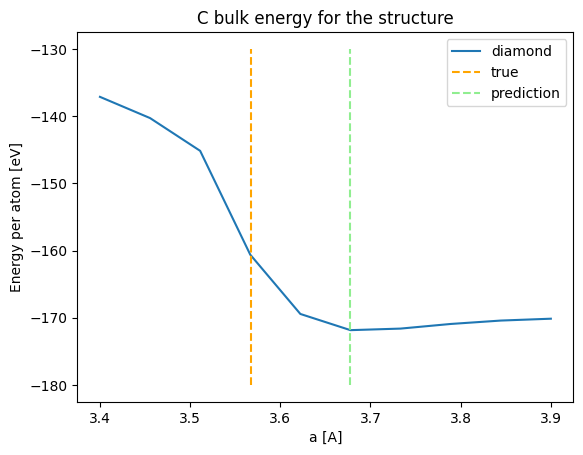

In [272]:
a_array = np.linspace(3.4, 3.9, 10)
plt.plot(a_array,diamond_energy, label="diamond")

i_min=np.argmin(np.array(diamond_energy))
a_pred=a_array[i_min]
a_true=3.567
print(f"argmin of diamond_energy per atom: {a_pred}") # argmin of diamond_energy per atom
print(f"percentage of error: {100*np.abs(a_pred-a_true)/a_true} %") # percentage of error

plt.xlabel("a [A]")
plt.vlines(a_true,-180,-130,color="orange",linestyle="--", label="true")
plt.vlines(a_pred,-180,-130,color="lightgreen",linestyle="--", label="prediction")
plt.ylabel("Energy per atom [eV]")
plt.legend()
plt.title("C bulk energy for the structure")
plt.show()

## 【Known problems】

1. AssertionError

### AssertionError
```
  File "/Users/syanase/share/idea2/dpdata/system.py", line 672, in rot_frame_lower_triangular
    assert np.linalg.det(rot) == 1
           ^^^^^^^^^^^^^^^^^^^^^^^
AssertionError
```

This is a deepmd-kit problem not OpenMX format one.

```
<Atoms.UnitVectors
     -3.5600000     0.0000000     3.5600000
      0.0000000     3.5600000     3.5600000
     -3.5600000     3.5600000     0.0000000
Atoms.UnitVectors>
```
has no problem, but
```
<Atoms.UnitVectors
     3.5600000     0.0000000     3.5600000
     0.0000000     3.5600000     3.5600000
     3.5600000     3.5600000     0.0000000
Atoms.UnitVectors>
```
makes a bug.

## 【Linkage to tools】

1. [OpenMX](https://www.openmx-square.org/)
1. [DeePMD-kit](https://github.com/deepmodeling/deepmd-kit)
1. [ASE](https://wiki.fysik.dtu.dk/ase/)

## 【Reference】
1. [MATLANTIS Atomistic Simulation Tutorial](https://docs.matlantis.com/atomistic-simulation-tutorial/ja/index.html)